In [1]:
year = 2022
day = 15

In [390]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import sys
import tqdm
from shapely.geometry import Point, Polygon, LineString
from copy import deepcopy
import time
import pandas as pd

In [4]:
sys.path.append("..")

In [5]:
from utilities.utils import get_puzzle, submit_answer, read_sample_data, extract_numbers

# Part One

In [6]:
part = "a"


You feel the ground rumble again as the distress signal leads you to a large network of subterranean tunnels. <br>You don't have time to search them all, but you don't need to: <br>your pack contains a set of deployable sensors that you imagine were originally built to locate lost Elves.<br>

The sensors aren't very powerful, but that's okay; <br>your handheld device indicates that you're close enough to the source of the distress signal to use them. <br>You pull the emergency sensor system out of your pack, hit the big button on top, and the sensors zoom off down the tunnels.

Once a sensor finds a spot it thinks will give it a good reading, it attaches itself<br> to a hard surface and begins monitoring for the nearest signal source beacon. <br>Sensors and beacons always exist at integer coordinates. Each sensor knows its own position and can determine the position of a beacon precisely; however, sensors can only lock on <br>to the one beacon closest to the sensor as measured by the Manhattan distance. <br>(There is never a tie where two beacons are the same distance to a sensor.)

This isn't necessarily a comprehensive map of all beacons in the area, though. <br>Because each sensor only identifies its closest beacon, if a sensor detects a beacon, <br>you know there are no other beacons that close or closer to that sensor. There could still be beacons that just happen to not be the closest beacon to any sensor.<br>

This sensor's closest beacon is at 2,10, and so you know there are no beacons that close or closer <br>(in any positions marked #).<br>

None of the detected beacons seem to be producing the distress signal, <br>so you'll need to work out where the distress beacon is by working out where it isn't. <br>For now, keep things simple by counting the positions where a beacon cannot possibly be along just a single row.

So, suppose you have an arrangement of beacons and sensors like in the example above and, just in the row where y=10, <br>you'd like to count the number of positions a beacon cannot possibly exist. The coverage from all sensors near that row looks like this:<br>

                 1    1    2    2<br>
       0    5    0    5    0    5<br>
 9 ...#########################...<br>
10 ..####B######################..<br>
11 .###S#############.###########.<br>
In this example, in the row where y=10, there are 26 positions where a beacon cannot be present.<br>

Consult the report from the sensors you just deployed. In the row where y=2000000, <br>how many positions cannot contain a beacon?

In [6]:
test = read_sample_data(15)

In [7]:
test

['Sensor at x=2, y=18: closest beacon is at x=-2, y=15',
 'Sensor at x=9, y=16: closest beacon is at x=10, y=16',
 'Sensor at x=13, y=2: closest beacon is at x=15, y=3',
 'Sensor at x=12, y=14: closest beacon is at x=10, y=16',
 'Sensor at x=10, y=20: closest beacon is at x=10, y=16',
 'Sensor at x=14, y=17: closest beacon is at x=10, y=16',
 'Sensor at x=8, y=7: closest beacon is at x=2, y=10',
 'Sensor at x=2, y=0: closest beacon is at x=2, y=10',
 'Sensor at x=0, y=11: closest beacon is at x=2, y=10',
 'Sensor at x=20, y=14: closest beacon is at x=25, y=17',
 'Sensor at x=17, y=20: closest beacon is at x=21, y=22',
 'Sensor at x=16, y=7: closest beacon is at x=15, y=3',
 'Sensor at x=14, y=3: closest beacon is at x=15, y=3',
 'Sensor at x=20, y=1: closest beacon is at x=15, y=3']

In [14]:
def init_map(data):
    x_values, y_values, sensors, beacons = [], [], [], []
    for d in data:
        s_x, s_y, b_x, b_y = extract_numbers(d)
        sensors.append((s_x, s_y))
        beacons.append((b_x, b_y))
        x_values.extend([s_x, b_x])
        y_values.extend([s_y, b_y])
    min_x = 0 if min(x_values) >= 0 else min(x_values)
    min_y = 0 if min(y_values) >= 0 else min(y_values)
    width = (max(x_values) - min(x_values)) + abs(min_x) + 1
    height = (max(y_values) - min(y_values)) + abs(min_y) + 1
    arr = np.zeros([height, width])
    corrected_sensors, corrected_beacons = [], []
    for sensor in sensors:
        corrected_sensors.append([sensor[1] + abs(min_y), sensor[0] + abs(min_x)])
        arr[sensor[1] + abs(min_y), sensor[0] + abs(min_x)] = 10
    for beacon in beacons:
        corrected_beacons.append([beacon[1] + abs(min_y), beacon[0] + abs(min_x)])
        arr[beacon[1] + abs(min_y), beacon[0] + abs(min_x)] = 20
    return arr, corrected_sensors, corrected_beacons

In [15]:
def manhattan(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

In [17]:
def mark_areas(m, sensors, beacons):
    x_delta = 0
    y_delta = 0
    for s, b in zip(sensors, beacons):
        s[0] += y_delta
        b[0] += y_delta
        s[1] += x_delta
        b[1] += x_delta
        distance = manhattan((s[0], s[1]), (b[0], b[1]))
        if s[0] < distance:
            delta = distance - s[0]
            new_row = np.zeros([delta, m.shape[1]])
            m = np.row_stack((new_row, m))
            s[0] += delta
            y_delta += delta
            # sensors = [[sensor[0] + delta, sensor[1]] for sensor in sensors]
            # beacons = [[beacon[0] + delta, beacon[1]] for beacon in beacons]
        if m.shape[0] - s[0] < distance:
            delta = distance - (m.shape[0] - s[0]) + 1
            print(f"adding {delta} bottom rows. M height = {m.shape[0]} and sensor = {s[0]} and distance = {distance}")
            new_row = np.zeros([delta, m.shape[1]])
            m = np.row_stack((m, new_row))
        if s[1] < distance:
            delta = distance - s[1]
            print(f"{s}, {b} -> {distance}")
            new_col = np.zeros([m.shape[0], delta])
            m = np.column_stack((new_col, m))
            s[1] += delta
            x_delta += delta
            # sensors = [[sensor[0], sensor[1] + delta] for sensor in sensors]
            # beacons = [[beacon[0], beacon[1] + delta] for beacon in beacons]
        if m.shape[1] - s[1] < distance:
            delta = distance - (m.shape[1] - s[1])
            new_row = np.zeros([m.shape[0], delta])
            m = np.column_stack((m, new_col))
        for i in range(m.shape[0]):
            for j in range(m.shape[1]):
                if manhattan((s[0], s[1]), (i, j)) <= distance:
                    if m[i, j] == 0:
                        m[i, j] = 5
    return m, y_delta, x_delta

In [18]:
def extract_impossible_positions(row_idx, rows_added, m):
    row_idx += rows_added
    row = m[row_idx, :]
    n = len([p for p in row.tolist() if p == 5])
    return n

In [19]:
m, sensors, beacons = init_map(test)

In [22]:
mm, rows_added, cols_added = mark_areas(m, sensors[2:3], beacons[2:3])

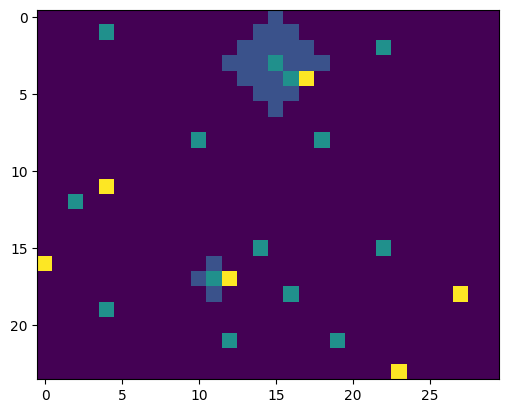

In [23]:
plt.imshow(mm)

In [228]:
extract_impossible_positions(10, rows_added, mm)

26

## real data

In [11]:
data = get_puzzle(year=2022, day=15)
data = data.split("\n")
data

['Sensor at x=3772068, y=2853720: closest beacon is at x=4068389, y=2345925',
 'Sensor at x=78607, y=2544104: closest beacon is at x=-152196, y=4183739',
 'Sensor at x=3239531, y=3939220: closest beacon is at x=3568548, y=4206192',
 'Sensor at x=339124, y=989831: closest beacon is at x=570292, y=1048239',
 'Sensor at x=3957534, y=2132743: closest beacon is at x=3897332, y=2000000',
 'Sensor at x=1882965, y=3426126: closest beacon is at x=2580484, y=3654136',
 'Sensor at x=1159443, y=3861139: closest beacon is at x=2580484, y=3654136',
 'Sensor at x=2433461, y=287013: closest beacon is at x=2088099, y=-190228',
 'Sensor at x=3004122, y=3483833: closest beacon is at x=2580484, y=3654136',
 'Sensor at x=3571821, y=799602: closest beacon is at x=3897332, y=2000000',
 'Sensor at x=2376562, y=1539540: closest beacon is at x=2700909, y=2519581',
 'Sensor at x=785113, y=1273008: closest beacon is at x=570292, y=1048239',
 'Sensor at x=1990787, y=38164: closest beacon is at x=2088099, y=-190228

### The numpy array method used for test data cannot work for the real data as the array is huge - OOM error

### Instead lets create a sensor class 
#### The sensor class will record the sensors position, the closest beacon position, the distance to beacon and a list of of all positions within that distance

In [496]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def get_coord(self):
        return [self.x, self.y]
    
    def increment_x(self):
        self.x += 1

    def increment_y(self):
        self.y += 1
        
    def decrement_x(self):
        self.x -= 1
        
    def decrement_y(self):
        self.y -= 1
        

In [956]:
class Diamond:
    def __init__(self, top, left, right, bottom):
        self.top = Point(top[0], top[1])
        self.left = Point(left[0], left[1])
        self.right = Point(right[0], right[1])
        self.bottom = Point(bottom[0], bottom[1])
        self.perimeter = None
        self.perimeter_dict = {}
        self.extract_perimeter()
        
    def extract_perimeter(self):
        segments = [(self.top, self.right), 
                    (self.top, self.left), 
                    (self.left, self.bottom), 
                    (self.right, self.bottom)]
        in_x = [True, False, True, False]
        in_y = [True, True, True, True]
        for segment, x, y in tqdm.tqdm(zip(segments, in_x, in_y)):
            if self.perimeter is None:
                self.perimeter = self.extract_segment(deepcopy(segment[0]), deepcopy(segment[1]), x, y)
            else:
                self.perimeter = np.row_stack((self.perimeter, self.extract_segment(deepcopy(segment[0]), deepcopy(segment[1]), x, y)))
        print(f"{self.perimeter.shape[0]} points in perimeter!")
        for row in self.perimeter:
            if 0 < row[1] < 4000000:
                if row[1] in self.perimeter_dict.keys():
                    self.perimeter_dict[row[1]].append(row[0])
                else:
                    self.perimeter_dict[row[1]] = [row[0]]
        
    def extract_segment(self, a, b, increment_x=True, increment_y=True):
        if increment_x and increment_y:
            xs = list(range(a.get_coord()[0], b.get_coord()[0]+1))
            ys = list(range(a.get_coord()[1], b.get_coord()[1]+1))
        elif increment_y and not increment_x:
            xs = list(range(b.get_coord()[0], a.get_coord()[0]+1))
            ys = list(range(a.get_coord()[1], b.get_coord()[1]+1))
            ys.reverse()
        points = np.stack((xs, ys), axis=1)
        return points
    
    def extract_tangent(self, row_idx):
        outer_values = self.perimeter[np.where(self.perimeter[:, 1] == row_idx)]
        if len(outer_values) == 0:
            return []
        elif len(outer_values) == 1:
            return outer_values[0].tolist()
        else:
            assert len(outer_values) == 2
            outer_col_values = outer_values[:, 0]
            col_values = np.array((range(np.min(outer_col_values), np.max(outer_col_values)+1)))
            row = np.full([len(col_values)], row_idx)
            coords = np.stack((col_values, row), axis=1)
            return coords
        
    def extract_perimeter_points(self, row_idx, quick=False):
        if quick:
            return self.perimeter_dict.get(row_idx, [])
        else:
            outer_values = self.perimeter[np.where(self.perimeter[:, 1] == row_idx)]
        return outer_values

In [957]:
class Sensor:
    def __init__(self, position: tuple, beacon_position: tuple):
        self.position = position
        self.beacon_position = beacon_position
        self.distance = self.calculate_distance()
        print(f"Distance = {self.distance}")
        self.diamond = None
        self.detect_impossible_positions()
        
    def calculate_distance(self, a=None, b=None):
        a = self.position if a is None else a
        b = self.beacon_position if b is None else b
        distance = abs(a[0] - b[0]) + abs(a[1] - b[1])
        return distance
        
    def detect_impossible_positions(self):
        top = deepcopy(self.position)
        right = deepcopy(self.position)
        left = deepcopy(self.position)
        bottom = deepcopy(self.position)
        
        top[1] -= self.distance
        right[0] += self.distance
        left[0] -= self.distance
        bottom[1] += self.distance 
        
        self.diamond = Diamond(top, left, right, bottom)
        
    def extract_row(self, row_idx: int, return_n: bool = False):
        row = self.diamond.extract_tangent(row_idx)
        if return_n:
            return row.shape[0]
        else:
            return row

In [958]:
def init_sensors(data):
    sensors = []
    for d in data:
        s_x, s_y, b_x, b_y = extract_numbers(d)
        sensor = Sensor([s_x, s_y], [b_x, b_y])
        sensors.append(sensor)
    return sensors

In [1045]:
sensors = init_sensors(test)

row_idx = 10
pos = None
sensor_positions = list(set([tuple(sensor.position) for sensor in sensors]))
sensor_positions = [list(s) for s in sensor_positions]
counted_sensors = []
sensor_count = 0
beacon_count = 0
beacon_positions = list(set([tuple(sensor.beacon_position) for sensor in sensors]))
beacon_positions = [list(b) for b in beacon_positions]
counted_beacons = []
for sensor in sensors:
    ps = sensor.extract_row(row_idx)
    sensor_count += len([s for s in sensor_positions if s[1] == row_idx and s not in counted_sensors])
    counted_sensors.extend([s for s in sensor_positions if s[1] == row_idx])
    beacon_count += len([b for b in beacon_positions if b[1] == row_idx and b not in counted_beacons])
    counted_beacons.extend([b for b in beacon_positions if b[1] == row_idx])
    if pos is None and len(ps) > 0:
        pos = ps.copy()
    elif len(ps) == 0:
        pass
    else:
        pos = np.row_stack((pos, ps))
pos = np.unique(pos, axis=0)
print(pos.shape[0] - sensor_count - beacon_count)

Distance = 7


4it [00:00, 1135.36it/s]


32 points in perimeter!
Distance = 1


4it [00:00, 14755.69it/s]


8 points in perimeter!
Distance = 3


4it [00:00, 4269.01it/s]


16 points in perimeter!
Distance = 4


4it [00:00, 3412.78it/s]


20 points in perimeter!
Distance = 4


4it [00:00, 4106.02it/s]


20 points in perimeter!
Distance = 5


4it [00:00, 14860.24it/s]


24 points in perimeter!
Distance = 9


4it [00:00, 3617.34it/s]


40 points in perimeter!
Distance = 10


4it [00:00, 3984.14it/s]


44 points in perimeter!
Distance = 3


4it [00:00, 15505.74it/s]


16 points in perimeter!
Distance = 8


4it [00:00, 7767.23it/s]


36 points in perimeter!
Distance = 6


4it [00:00, 2597.09it/s]


28 points in perimeter!
Distance = 5


4it [00:00, 15046.83it/s]


24 points in perimeter!
Distance = 1


4it [00:00, 7169.75it/s]


8 points in perimeter!
Distance = 7


4it [00:00, 10611.77it/s]

32 points in perimeter!
26


In [937]:
sensors = init_sensors(data)

Distance = 804116


4it [00:00,  8.05it/s]


3216468 points in perimeter!
Distance = 1870438


4it [00:02,  1.99it/s]


7481756 points in perimeter!
Distance = 595989


4it [00:00,  9.43it/s]


2383960 points in perimeter!
Distance = 289576


4it [00:00, 19.35it/s]


1158308 points in perimeter!
Distance = 192945


4it [00:00, 31.39it/s]

771784 points in perimeter!


Distance = 925529


4it [00:00,  6.12it/s]


3702120 points in perimeter!
Distance = 1628044


4it [00:01,  3.58it/s]


6512180 points in perimeter!
Distance = 822603


4it [00:00,  7.47it/s]


3290416 points in perimeter!
Distance = 593941


4it [00:00,  9.53it/s]


2375768 points in perimeter!
Distance = 1525909


4it [00:01,  3.73it/s]


6103640 points in perimeter!
Distance = 1304388


4it [00:00,  4.52it/s]


5217556 points in perimeter!
Distance = 439590


4it [00:00, 12.78it/s]


1758364 points in perimeter!
Distance = 325704


4it [00:00, 17.22it/s]


1302820 points in perimeter!
Distance = 332346


4it [00:00, 16.58it/s]


1329388 points in perimeter!
Distance = 472955


4it [00:00, 11.57it/s]


1891824 points in perimeter!
Distance = 467689


4it [00:00, 12.09it/s]


1870760 points in perimeter!
Distance = 1562082


4it [00:01,  3.40it/s]


6248332 points in perimeter!
Distance = 736132


4it [00:00,  7.67it/s]


2944532 points in perimeter!
Distance = 1040798


4it [00:00,  4.79it/s]


4163196 points in perimeter!
Distance = 1304913


4it [00:00,  4.19it/s]


5219656 points in perimeter!
Distance = 1289919


4it [00:00,  4.51it/s]


5159680 points in perimeter!
Distance = 137205


4it [00:00, 40.73it/s]

548824 points in perimeter!


Distance = 736599


4it [00:00,  6.97it/s]


2946400 points in perimeter!
Distance = 929761


4it [00:00,  5.29it/s]


3719048 points in perimeter!
Distance = 548935


4it [00:00, 10.47it/s]


2195744 points in perimeter!
Distance = 375882


4it [00:00, 14.60it/s]


1503532 points in perimeter!


In [760]:
%%time
start=time.time()
row_idx = 2000000
pos = None
sensor_positions = list(set([tuple(sensor.position) for sensor in sensors]))
sensor_positions = [list(s) for s in sensor_positions]
counted_sensors = []
sensor_count = 0
beacon_count = 0
beacon_positions = list(set([tuple(sensor.beacon_position) for sensor in sensors]))
beacon_positions = [list(b) for b in beacon_positions]
counted_beacons = []
for sensor in tqdm.tqdm(sensors):
    ps = sensor.extract_row(row_idx)
    sensor_count += len([s for s in sensor_positions if s[1] == row_idx and s not in counted_sensors])
    counted_sensors.extend([s for s in sensor_positions if s[1] == row_idx])
    beacon_count += len([b for b in beacon_positions if b[1] == row_idx and b not in counted_beacons])
    counted_beacons.extend([b for b in beacon_positions if b[1] == row_idx])
    # ps = [p for p in ps if p.tolist() not in sensor_positions and p.tolist() not in beacon_positions]
    # ps = np.array([row for row in ps if not any(np.equal(beacon_positions, row).all(1)) and not any(np.equal(sensor_positions, row).all(1))])
    if pos is None and len(ps) > 0:
        pos = ps.copy()
    elif len(ps) == 0:
        pass
    else:
        pos = np.row_stack((pos, ps))
print(time.time() - start)
print(pd.DataFrame(pos).drop_duplicates().shape[0] - sensor_count - beacon_count)

100%|██████████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 16.84it/s]


1.5464868545532227
5299855
CPU times: user 2.24 s, sys: 590 ms, total: 2.83 s
Wall time: 2.83 s


# Part Two

Your handheld device indicates that the distress signal is coming from a beacon nearby. <br>The distress beacon is not detected by any sensor, but the distress beacon must have x and y coordinates <br>each no lower than 0 and no larger than 4000000.<br>

To isolate the distress beacon's signal, you need to determine its tuning frequency, which can be found by multiplying its x coordinate by 4000000 and then adding its y coordinate.<br>

In the example above, the search space is smaller: instead, the x and y coordinates can each be at most 20. <br>With this reduced search area, there is only a single position that could have a beacon: x=14, y=11. <br>The tuning frequency for this distress beacon is 56000011.

Find the only possible position for the distress beacon. What is its tuning frequency?

For a given row, extract the perimeter coordinates for a given sensor and find the lines where the coordinates do not overlap within a range of 0-4000000

In [ ]:
part = "b"

In [1050]:
sensors = init_sensors(data)

Distance = 804116


4it [00:00,  5.69it/s]


3216468 points in perimeter!
Distance = 1870438


4it [00:01,  2.63it/s]


7481756 points in perimeter!
Distance = 595989


4it [00:00,  8.84it/s]


2383960 points in perimeter!
Distance = 289576


4it [00:00, 17.98it/s]


1158308 points in perimeter!
Distance = 192945


4it [00:00, 30.14it/s]

771784 points in perimeter!


Distance = 925529


4it [00:00,  5.77it/s]


3702120 points in perimeter!
Distance = 1628044


4it [00:01,  3.62it/s]


6512180 points in perimeter!
Distance = 822603


4it [00:00,  7.50it/s]


3290416 points in perimeter!
Distance = 593941


4it [00:00,  8.95it/s]


2375768 points in perimeter!
Distance = 1525909


4it [00:01,  3.86it/s]


6103640 points in perimeter!
Distance = 1304388


4it [00:00,  4.65it/s]


5217556 points in perimeter!
Distance = 439590


4it [00:00, 12.67it/s]


1758364 points in perimeter!
Distance = 325704


4it [00:00, 17.46it/s]


1302820 points in perimeter!
Distance = 332346


4it [00:00, 16.47it/s]


1329388 points in perimeter!
Distance = 472955


4it [00:00, 11.81it/s]


1891824 points in perimeter!
Distance = 467689


4it [00:00, 12.07it/s]


1870760 points in perimeter!
Distance = 1562082


4it [00:01,  3.68it/s]


6248332 points in perimeter!
Distance = 736132


4it [00:00,  7.86it/s]


2944532 points in perimeter!
Distance = 1040798


4it [00:00,  5.55it/s]


4163196 points in perimeter!
Distance = 1304913


4it [00:01,  2.92it/s]


5219656 points in perimeter!
Distance = 1289919


4it [00:00,  4.45it/s]


5159680 points in perimeter!
Distance = 137205


4it [00:00, 35.80it/s]

548824 points in perimeter!


Distance = 736599


4it [00:00,  7.40it/s]


2946400 points in perimeter!
Distance = 929761


4it [00:00,  5.54it/s]


3719048 points in perimeter!
Distance = 548935


4it [00:00, 10.53it/s]


2195744 points in perimeter!
Distance = 375882


4it [00:00, 16.27it/s]


1503532 points in perimeter!


In [ ]:
def order_coordinates(perimeter_coords, verbose=True, min_val=0, max_val=4_000_000):
    perimeter_coords = sorted(perimeter_coords)
    used_coords = []
    c = perimeter_coords.pop(0)
    used_coords.append(deepcopy(c))
    last_length = len(perimeter_coords)
    gaps = []
    while len(perimeter_coords) > 0:
        for i, c2 in enumerate(perimeter_coords):
            if c2[0] <= c[1]:
                if c2[1] <= c[1]:
                    if verbose:
                        print(f"{c2} is encompassed by {c}")
                    _ = perimeter_coords.pop(i)
                else:
                    if verbose:
                        print(f"{c2} overlaps {c} and extends the right hand range")
                    _ = perimeter_coords.pop(i)
                    c[1] = c2[1]
                    used_coords.append(deepcopy(c))
                    break
            else:
                if verbose:
                    print(f"{c2} does not overlap {c}")
        if len(perimeter_coords) == last_length:
            next_c = perimeter_coords.pop(0)
            if verbose:
                print(f"Gap found between {c} and {next_c}")
            used_coords.append(next_c)
            gaps.append([c[1], next_c[0]])
            c[1] = next_c[1]
            c[0] = next_c[0]
        else:
            last_length = len(perimeter_coords)
    # used_coords.extend(perimeter_coords)
    if used_coords[0][0] > min_val: 
        gaps.append([min_val, used_coords[0][0]])
    if c[1] < max_val:
        gaps.append([c[1], max_val])
    return used_coords, gaps

In [1054]:
%%time
rows = []
max_v = 4_000_000

for row_idx in tqdm.tqdm(range(1, max_v)):
# row_idx = 10

    perimeter_coords = []
    for s in sensors:
        coords = list(set(s.diamond.extract_perimeter_points(row_idx, True)))
        if len(coords) == 2:
            perimeter_coords.append(sorted(coords))

    used_coords, gaps = order_coordinates(perimeter_coords, False, min_val=0, max_val=max_v)
    if len(gaps) > 0:
        rows.append(row_idx)
        break
# for i, line in enumerate(used_coords):
#     plt.plot([line[0], line[1]], [i, i] , 'k-', lw=2)
# for gap in gaps:
#     rect=mpatches.Rectangle((gap[0], -1),gap[1]-gap[0],len(used_coords)+1, 
#                             fill = True,
#                             color = "purple",
#                             alpha=0.1,
#                             linewidth = 0.1)
#     plt.gca().add_patch(rect)

 82%|████████████████████████████████████████▎        | 3289728/3999999 [03:14<00:42, 16886.83it/s]

CPU times: user 2min 57s, sys: 11.6 s, total: 3min 9s
Wall time: 3min 14s


In [ ]:
rows

[3289729]

0 -> [3403961, 4140175]
1 -> [-1046206, 1203420]
5 -> [2672097, 1093833]
6 -> [102809, 2216077]
8 -> [2604285, 3403959]
13 -> [3854552, 4133004]
16 -> [1930761, 965867]
18 -> [-642552, 1035390]
22 -> [2586669, 3403959]
24 -> [3403961, 3749955]
coordinate of beacon = 3403960, 3289729


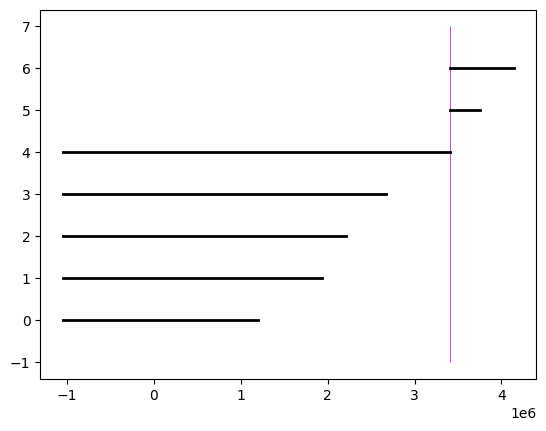

In [1061]:
row_idx = rows[0]

perimeter_coords = []
for i, s in enumerate(sensors):
    coords = list(set(s.diamond.extract_perimeter_points(row_idx, True)))
    if len(coords) == 2:
        print(f"{i} -> {coords}")
        perimeter_coords.append(sorted(coords))

used_coords, gaps = order_coordinates(perimeter_coords, False, 0, 4_000_000)
gap_x = gaps[0][0] + 1
print(f"coordinate of beacon = {gap_x}, {row_idx}")

for i, line in enumerate(used_coords):
    plt.plot([line[0], line[1]], [i, i] , 'k-', lw=2)
for gap in gaps:
    rect=mpatches.Rectangle((gap[0], -1),gap[1]-gap[0],len(used_coords)+1, 
                            fill = True,
                            color = "purple",
                            alpha=0.9,
                            linewidth = 0.5)
    plt.gca().add_patch(rect)

In [1068]:
answer = int((gap_x * 4000000) + row_idx)
print(f"Answer to part B = {answer}")

Answer to part B = 13615843289729


In [1067]:
submit_answer(answer, 'b', day, year)

Part b already solved with same answer: 13615843289729
